# 6.5 Clustering

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Standardizing data
#### 3. The elbow technique
#### 3. k-means clustering

## 1. Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pylab as pl

In [2]:
# This option ensures that graphs are displayed within the notebook without the need to "call" them specifically.
%matplotlib inline

In [3]:
# define path
path = r'/Users/yusufsalk/Documents/Chocolate Bar Analysis'

In [4]:
#import data
df = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'chocolate_bar.pkl'))

In [5]:
df.shape

(1795, 8)

In [6]:
df.head()

,company_name,specific_bean_origin,ref,review_date,cocoa_percentage,company_location,rating,broad_bean_origin
0,A. Morin,Agua Grande,1876,2016,0.63,France,3.75,Sao Tome
1,A. Morin,Kpime,1676,2015,0.70,France,2.75,Togo
2,A. Morin,Atsane,1676,2015,0.70,France,3.00,Togo
3,A. Morin,Akata,1680,2015,0.70,France,3.50,Togo
4,A. Morin,Quilla,1704,2015,0.70,France,3.50,Peru


In [7]:
# dropping unnecessary columns
df = df.drop(columns = ['company_name', 'specific_bean_origin', 'ref', 'company_location', 'broad_bean_origin'])

In [8]:
df.head()

,review_date,cocoa_percentage,rating
0,2016,0.63,3.75
1,2015,0.70,2.75
2,2015,0.70,3.00
3,2015,0.70,3.50
4,2015,0.70,3.50


## 2. Standardizing data

In [9]:
# use a Standard Scaler to standardize the data
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df)

In [10]:
# fit the standardized data using PCA
pca = PCA()
pca.fit(segmentation_std)

PCA()

In [11]:
# show how much variance is explained by each of the three components
pca.explained_variance_ratio_

array([0.3925076 , 0.34451211, 0.26298029])

Text(0, 0.5, 'Cumulative Explained Variance')

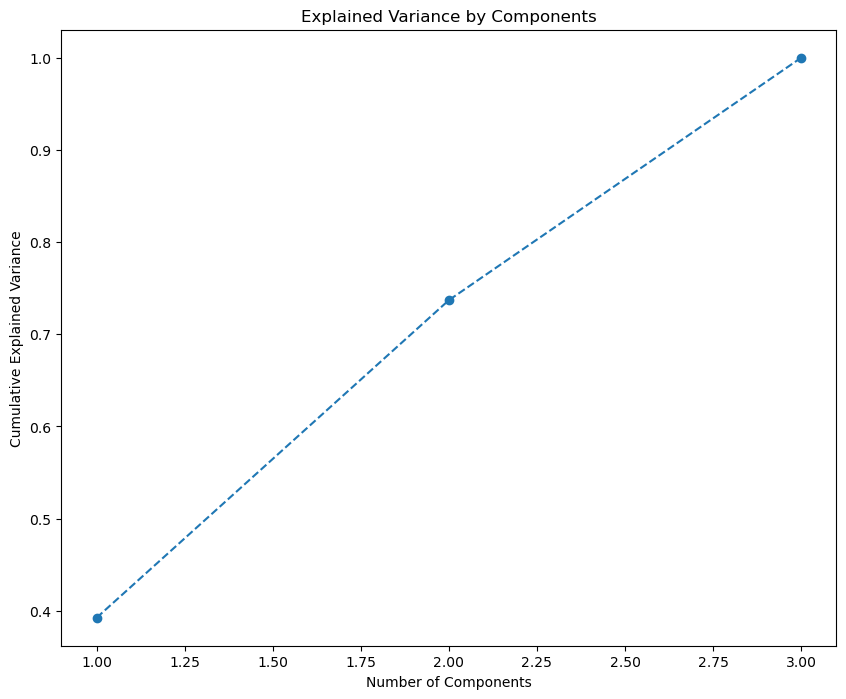

In [12]:
plt.figure(figsize = (10,8))
plt.plot(range(1,4), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

Keeping two components is enough here, as they preserve around 80 % of the variance.

In [13]:
# choose two components according to the above findings
pca = PCA(n_components = 2)

In [14]:
# fit the model to data
pca.fit(segmentation_std)

PCA(n_components=2)

In [15]:
# extract calculated resulting components scores for the data set
pca.transform(segmentation_std)

array([[-2.06899385, -0.5049137 ],
       [ 0.24701396, -0.5626163 ],
       [-0.13638079, -0.61346459],
       ...,
       [-1.0129325 ,  0.85658163],
       [-0.92403569,  1.14525954],
       [-0.15087606,  1.25211823]])

In [16]:
scores_pca = pca.transform(segmentation_std)

## 3. The elbow technique

In [17]:
# define the range of potential clusters in the data
num_cl = range(1, 10)
kmeans = [KMeans(n_clusters=i, n_init=10) for i in num_cl] # defines k-means clusters in the range assigned above.

In [18]:
# create a score that represents a rate of variation for the given cluster option
score = [kmeans[i].fit(scores_pca).score(scores_pca) for i in range(len(kmeans))]

score

[-3968.8511222301527,
 -2640.0193420545365,
 -1778.9443022132461,
 -1420.1134383371627,
 -1139.6984914128261,
 -952.9725528735861,
 -837.8547091185231,
 -726.702477711669,
 -634.6686579627742]

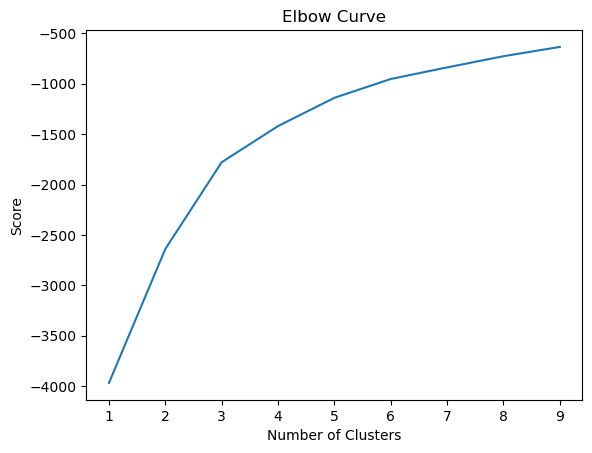

In [19]:
# plot the elbow curve using PyLab

pl.plot(num_cl, score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

Looking at the chart above, there's a jump from two to three on the x-axis, but after that, the curve straightens out. This means that the optimal count for clusters is three.

## 4. k-means clustering

In [20]:
# create the k-means object
kmeans = KMeans(n_clusters = 3, n_init = 10)

In [21]:
# fit the k-means object to the data
kmeans.fit(scores_pca)

KMeans(n_clusters=3, n_init=10)

In [22]:
# create a new df and add the PCA scores and assigned clusters
df_segm_pca_kmeans = pd.concat([df.reset_index(drop=True),pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-2: ] = ['Component 1', 'Component 2']
df_segm_pca_kmeans['Segment k-means PCA'] = kmeans.labels_

In [23]:
df_segm_pca_kmeans.head()

,review_date,cocoa_percentage,rating,Component 1,Component 2,Segment k-means PCA
0,2016,0.63,3.75,-2.068994,-0.504914,0
1,2015,0.70,2.75,0.247014,-0.562616,0
2,2015,0.70,3.00,-0.136381,-0.613465,0
3,2015,0.70,3.50,-0.903170,-0.715161,0
4,2015,0.70,3.50,-0.903170,-0.715161,0


In [24]:
# check how many observations fall into each cluster
df_segm_pca_kmeans['Segment k-means PCA'].value_counts()

0    885
2    511
1    399
Name: Segment k-means PCA, dtype: int64

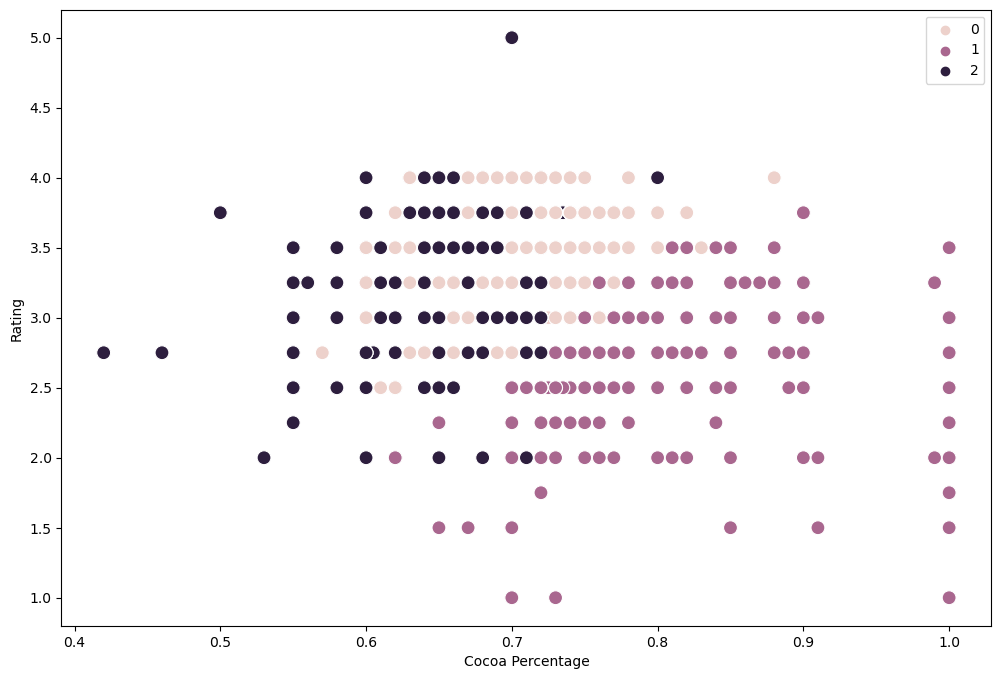

In [25]:
# Plot the clusters for the "rating" and "cocoa_percentage" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df_segm_pca_kmeans['cocoa_percentage'], y=df_segm_pca_kmeans['rating'], hue=kmeans.labels_, s=100) 
# Here, we're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points we want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('Cocoa Percentage') # Label x-axis.
plt.ylabel('Rating') # Label y-axis.
plt.show()

The first cluster, in purple (coded as “1” in the legend), is also the most populated cluster. It gathers the data points with relatively higher cocoa percentages and lower ratings than other clusters on average.

The second cluster, in dark purple (coded as “2” in the legend), includes points with relatively higher ratings than other clusters and lower cocoa percentages than the first cluster—but higher on average than the third cluster. 

The third cluster, in pink (coded as “0” in the legend), contains the points with lower cocoa percentages and lower ratings than the second cluster—but higher on average than the first cluster.

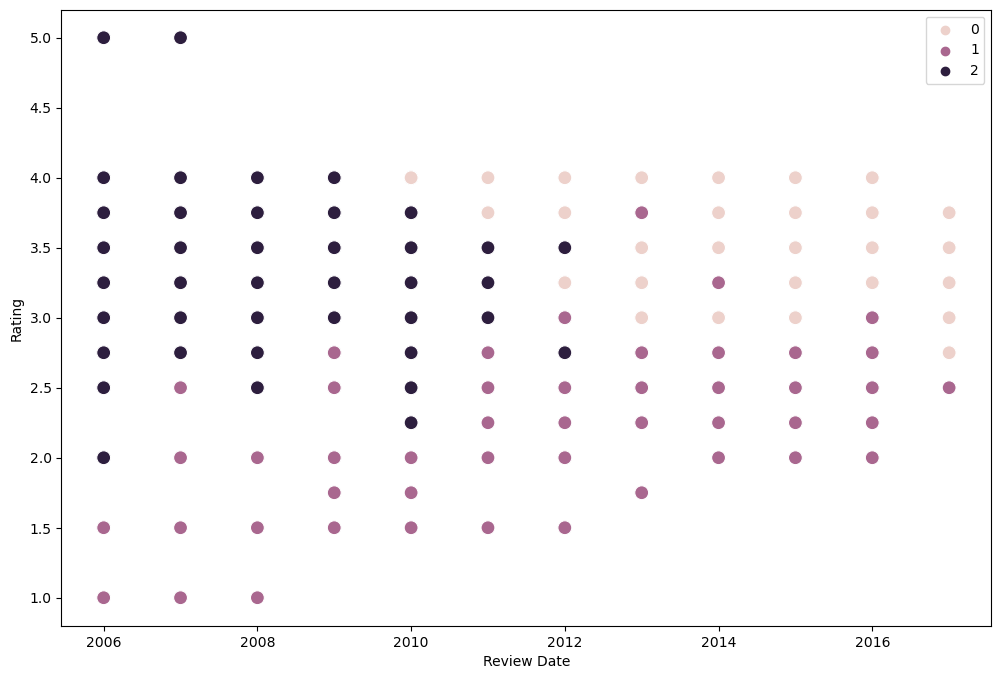

In [26]:
# Plot the clusters for the "rating" and "review_date" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df_segm_pca_kmeans['review_date'], y=df_segm_pca_kmeans['rating'], hue=kmeans.labels_, s=100) 
# Here, we're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points we want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('Review Date') # Label x-axis.
plt.ylabel('Rating') # Label y-axis.
plt.show()

In the scatterplot above, the clusters don't make much more sense. However, while data points that occurred in early years scattered between 1 and 5, they wedged into between 2.5 and 3.75 lately. This might be useful insight to explore the data further.

In [27]:
# create flags for different clusters
df_segm_pca_kmeans.loc[df_segm_pca_kmeans['Segment k-means PCA'] == 2, 'cluster'] = 'dark purple'
df_segm_pca_kmeans.loc[df_segm_pca_kmeans['Segment k-means PCA'] == 1, 'cluster'] = 'purple'
df_segm_pca_kmeans.loc[df_segm_pca_kmeans['Segment k-means PCA'] == 0, 'cluster'] = 'pink'

In [28]:
# calculate the descriptive statistics for the clusters
df_segm_pca_kmeans.groupby('cluster').agg({'rating':['mean', 'median'], 
                         'cocoa_percentage':['mean', 'median'], 
                         'review_date':['mean', 'median']})

rating        cocoa_percentage         review_date        
                 mean median             mean median         mean  median
cluster                                                                  
dark purple  3.203523   3.25         0.682407   0.70  2009.062622  2009.0
pink         3.397740   3.50         0.707028   0.70  2014.200000  2014.0
purple       2.693609   2.75         0.783346   0.76  2012.345865  2013.0

We could research more deeply about the "dark purple" cluster in the chart that plotting with rating and cocoa percentage, since it has the highest rating mean. Finding what common characteristics the data points in this cluster have could be useful to produce high-rating chocolate bars.